## Data exploration
* Perry Huang liwanh2@illinois.edu
* Yiqiu Song yiqius3@illinois.edu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the dataset and split the feature columns and ground truth column(s)

In [ ]:

dataset = pd.read_pickle("/content/drive/MyDrive/Deep Dive 12/ppd/dataset_cleaned.pkl")

df = dataset.copy()
df['month'] = df['date'].dt.month.astype('Int64')
df['month_sin'] = np.sin(2*np.pi*(df['month']/12))
df['month_cos'] = np.cos(2*np.pi*(df['month']/12))

df['year'] = df['date'].dt.year

feature_cols = [
    "building_name","street","town","district","county",
    "postcode","property_type","new_build","tenure",
    "transaction_category","postcode_sector"
]
label_col = "price_paid"



In [ ]:
df.columns

Index(['date', 'building_name', 'street', 'town', 'district', 'county',
       'postcode', 'postcode_outward', 'postcode_sector', 'property_type',
       'new_build', 'tenure', 'transaction_category', 'month_sin', 'month_cos',
       'month', 'price_paid', 'year'],
      dtype='object')

In [ ]:
df.head()

,date,building_name,street,town,district,county,postcode,postcode_outward,postcode_sector,property_type,new_build,tenure,transaction_category,month_sin,month_cos,month,price_paid,year
0,2015-10-23,338,CABLE STREET,LONDON,TOWER HAMLETS,GREATER LONDON,E1 0AE,E1,E1,F,N,L,A,-0.866025,0.5,10,455000,2015
1,2015-08-25,362,CABLE STREET,LONDON,TOWER HAMLETS,GREATER LONDON,E1 0AE,E1,E1,F,N,L,A,-0.866025,-0.5,8,378000,2015
2,2015-06-18,Lower Ground And Ground Floor Flat,CABLE STREET,LONDON,TOWER HAMLETS,GREATER LONDON,E1 0AH,E1,E1,F,N,L,A,0.0,-1.0,6,450000,2015
3,2015-10-02,Flat 10,CABLE STREET,LONDON,TOWER HAMLETS,GREATER LONDON,E1 0AN,E1,E1,F,N,L,A,-0.866025,0.5,10,225000,2015
4,2015-10-30,Flat 25,CABLE STREET,LONDON,TOWER HAMLETS,GREATER LONDON,E1 0AP,E1,E1,F,N,L,A,-0.866025,0.5,10,340000,2015


Split the dataset for trainning and testing (validation)

In [ ]:
for c in feature_cols:
    if c in df.columns:
        df[c] = df[c].astype("string").str.strip()

df = df[df[label_col].notna()].copy()
df[label_col] = df[label_col].astype(float)
df = df[df[label_col] > 0]

use_time_split = True

if use_time_split and 'date' in df.columns:
    df = df.sort_values('date')
    cut = int(len(df) * 0.8)
    train, valid = df.iloc[:cut], df.iloc[cut:]
else:
    from sklearn.model_selection import train_test_split
    train, valid = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

X_train, y_train = train[feature_cols], train[label_col]
X_valid, y_valid = valid[feature_cols], valid[label_col]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=20), feature_cols)
])

Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg_plain = Pipeline([
    ("prep", preprocess),
    ("lm", LinearRegression())
])

y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

reg_plain.fit(X_train, y_train_log)
pred_log_plain = reg_plain.predict(X_valid)
pred_plain     = np.expm1(pred_log_plain).clip(min=0)

mae  = mean_absolute_error(y_valid, pred)
rmse = np.sqrt(mean_squared_error(y_valid, pred))
r2   = r2_score(y_valid, pred)
print(f"[Ridge] MAE: £{mae:,.0f} | RMSE: £{rmse:,.0f} | R²: {r2:.3f}")

[Ridge] MAE: £446,532 | RMSE: £3,042,022 | R²: 0.069


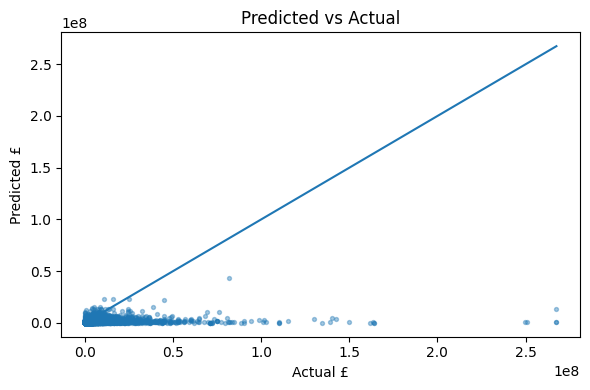

In [ ]:

plt.figure(figsize=(6,4))
plt.scatter(y_valid, pred, s=8, alpha=0.4)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()])
plt.title("Predicted vs Actual")
plt.xlabel("Actual £"); plt.ylabel("Predicted £"); plt.tight_layout(); plt.show()

The Logistic Regression model is performing a different task: classifying properties as high-value or low-value (based on the median).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

thr = y_train.median()
y_train_cls = (y_train >= thr).astype(int)
y_valid_cls = (y_valid >= thr).astype(int)

clf = Pipeline([
    ("prep", preprocess),
    ("logit", LogisticRegression(max_iter=200))
])

clf.fit(X_train, y_train_cls)
proba   = clf.predict_proba(X_valid)[:,1]
pred_cls= (proba >= 0.5).astype(int)

acc = accuracy_score(y_valid_cls, pred_cls)
auc = roc_auc_score(y_valid_cls, proba)
print(f"[Logistic] Acc: {acc:.3f} | ROC AUC: {auc:.3f} | threshold: £{thr:,.0f}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Logistic] Acc: 0.794 | ROC AUC: 0.883 | threshold: £520,000


The features are currently very bad at predicting the specific price(linear regression) but are quite good at classifying whether a property is in the top or bottom half of the market( Logistic Regression).

In [ ]:
results = pd.DataFrame({
    "Model": ["linear Regression", "Logistic Regression"],
    "Metric 1": ["R² = {:.3f}".format(r2), "Accuracy = {:.3f}".format(acc)],
    "Metric 2": ["RMSE = £{:,.0f}".format(rmse), "ROC AUC = {:.3f}".format(auc)]
})
results


,Model,Metric 1,Metric 2
0,linear Regression,R² = 0.069,"RMSE = £3,042,022"
1,Logistic Regression,Accuracy = 0.794,ROC AUC = 0.883
